In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
robot_frame_filenames = set([fname.split("_")[0] 
                             for fname in glob.glob("robotframes/*")])
habitat_frame_filenames = set([fname.split("_")[0] 
                               for fname in glob.glob("habitatframes/*")])

### What is the visual domain gap for depth?

1. Robot depth frames have a lot of zeros (object further than max depth, objects closer than min depth, object boundaries and all regions with high uncertainty) — we try to be as conservative as possible and only project points in which we're confident to the point cloud
2. Habitat depth frames don't have any zeros, depth is perfect within the (min depth, max depth) range, points closer than min depth are set to min depth, points further than max depth are set to max depth

### How to reconcile these?

Two options:
1. Get Habitat frames to match robot frames during training — we could apply some of the same processing steps we apply to robot depth frames, but (1) this would require re-training the policy and (2) this won't work with policies using a pre-trained depth encoder (as does the Habitat Web policy)
2. Get robot frames to match Habitat frames during inference — we cannot unzero the depth frame, can we access the depth frame pre processing and process it differently?

In [36]:
def visualize(fname, min_depth=0.5, max_depth=4.0):
    rgb = np.load(f"{fname}_rgb.npy")
    depth = np.load(f"{fname}_depth.npy")
    
    _, subplots = plt.subplots(1, 5, figsize=(15, 4))
    subplots[0].imshow(rgb)
    subplots[0].set_axis_off()
    subplots[1].imshow(depth)
    subplots[1].set_axis_off()
    subplots[2].imshow(depth == 0)
    subplots[2].set_axis_off()
    subplots[3].imshow(depth == min_depth)
    subplots[3].set_axis_off()
    subplots[4].imshow(depth == max_depth)
    subplots[4].set_axis_off()
    plt.show()
    
    print(f"Depth range: ({depth[depth != 0].min()}, {depth.max()})")
    print("_" * 40)

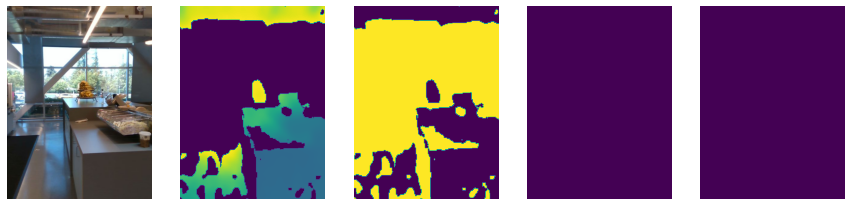

Depth range: (1.3070000410079956, 3.928999900817871)
________________________________________


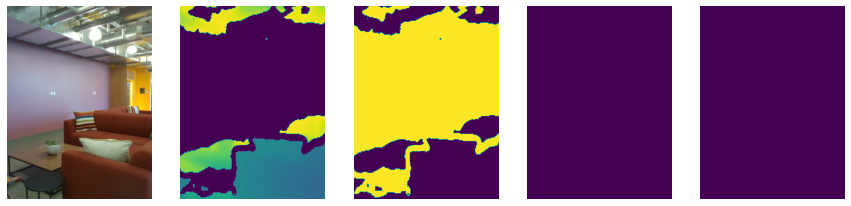

Depth range: (1.3600000143051147, 3.9739999771118164)
________________________________________


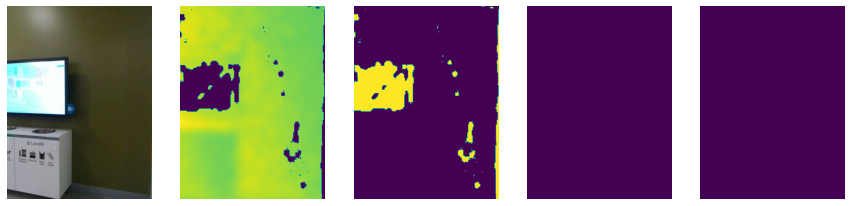

Depth range: (1.996000051498413, 2.694000005722046)
________________________________________


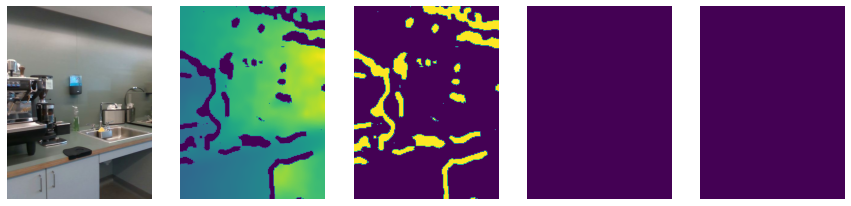

Depth range: (1.0520000457763672, 3.122999906539917)
________________________________________


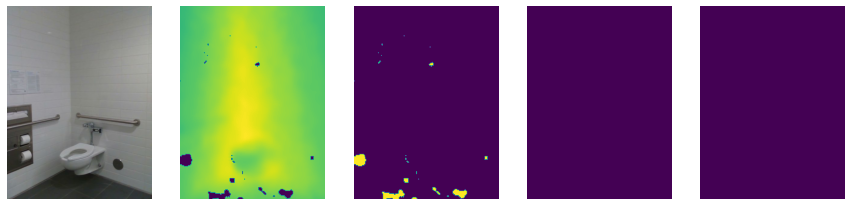

Depth range: (1.8890000581741333, 2.8420000076293945)
________________________________________


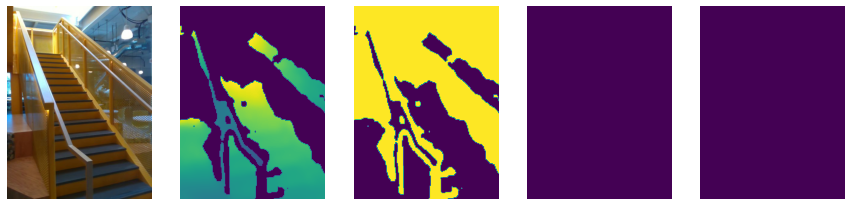

Depth range: (1.0920000076293945, 3.950000047683716)
________________________________________


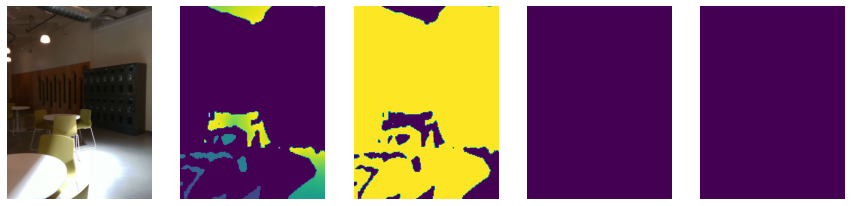

Depth range: (0.8019999861717224, 3.9739999771118164)
________________________________________


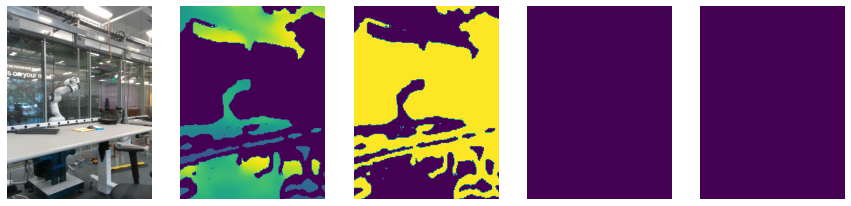

Depth range: (0.8980000019073486, 3.9739999771118164)
________________________________________


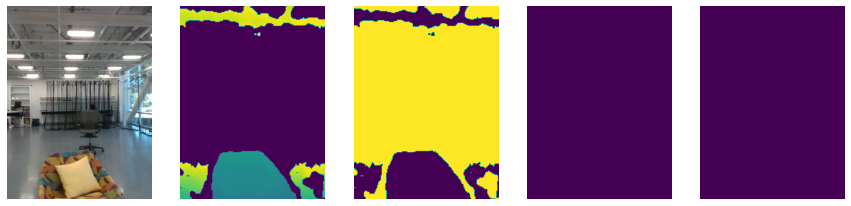

Depth range: (1.559000015258789, 3.9739999771118164)
________________________________________


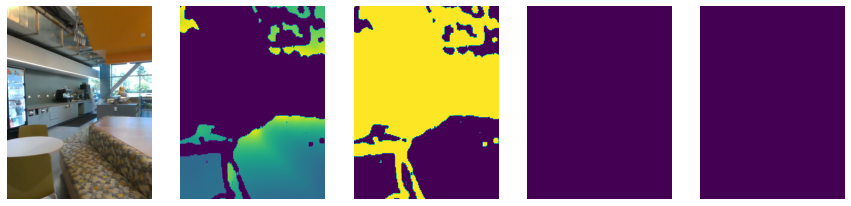

Depth range: (1.3329999446868896, 3.9709999561309814)
________________________________________


In [37]:
for fname in robot_frame_filenames:
    visualize(fname)

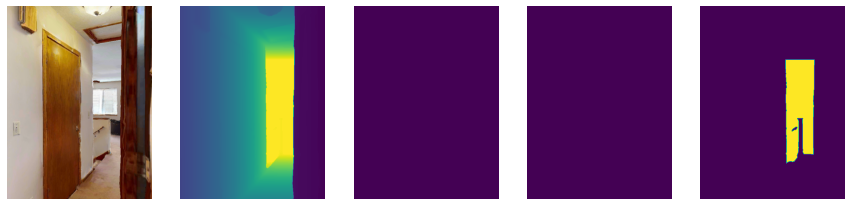

Depth range: (0.5376867055892944, 4.0)
________________________________________


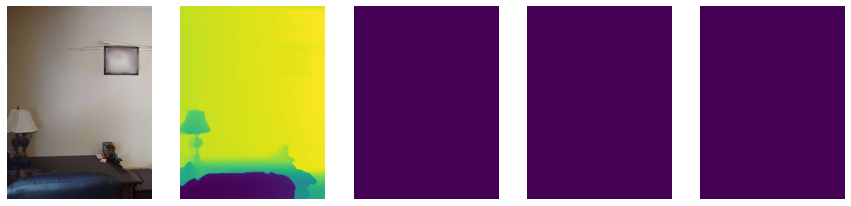

Depth range: (0.5991880297660828, 1.8661028146743774)
________________________________________


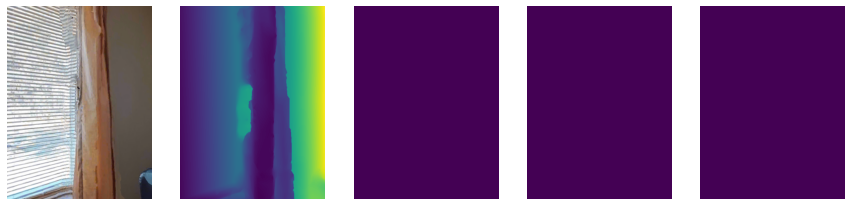

Depth range: (0.8741726875305176, 1.485736608505249)
________________________________________


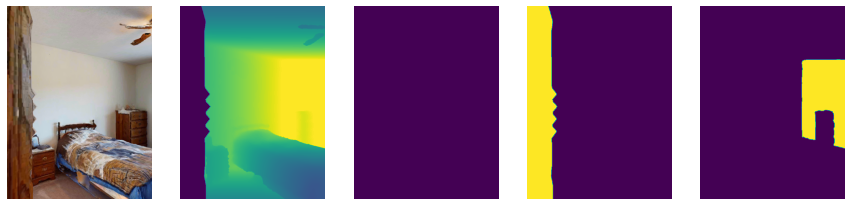

Depth range: (0.5, 4.0)
________________________________________


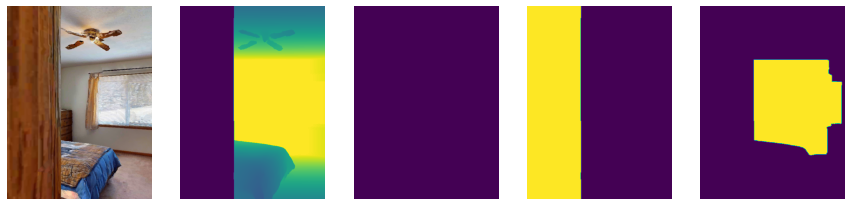

Depth range: (0.5, 4.0)
________________________________________


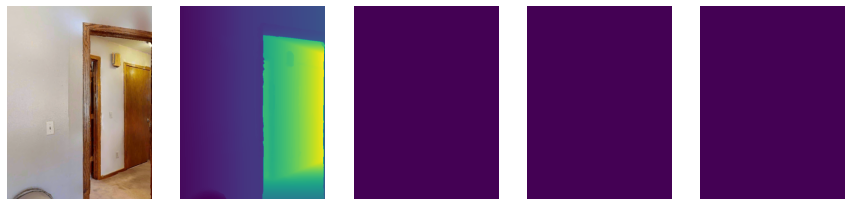

Depth range: (1.1144134998321533, 3.577343702316284)
________________________________________


In [34]:
for fname in habitat_frame_filenames:
    visualize(fname)